### 环境设置

In [1]:
import sys
import os

# 添加 src 到路径，便于导入
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "../src")))

### 导入所需要的包

In [2]:
from typing import List, Set, Tuple
from shapely.geometry import Point, Polygon, LineString, box
import matplotlib.pyplot as plt
from heapq import heappush, heappop

# 自定义模块导入
from CADAlgo.check import is_valid_line
from CADAlgo.generate import generate_connection_lines, generate_sampled_points

### 设置 notebook 的 matplotlib 后端

In [3]:
# 使用 notebook 的 matplotlib 后端
%matplotlib inline

### 初始化条件
  - 多边形边界
  - 引出点
  - 障碍物

In [4]:
# 定义多边形边界和关键点
polygon = Polygon([(0, 0), (50, 25), (100, 0), (100, 100), (0, 100), (25, 50)])
points = [
    Point(25, 25),
    Point(75, 25),
    Point(75, 75),
    Point(25, 75),
    Point(27.56, 20.61),
    Point(30.23, 21.46),
    Point(30, 30),
]

obstacles = [box(84, 72, 88, 78)]

### 生成连接

In [5]:
# 生成连接线
lines = generate_connection_lines(points, polygon, obstacles, samples_per_edge=20)

### 绘制图片

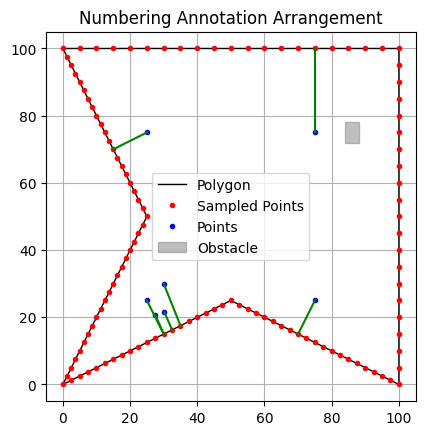

In [6]:
_, ax = plt.subplots()

# 绘制多边形
x_poly, y_poly = polygon.exterior.xy
ax.plot(x_poly, y_poly, "k-", linewidth=1, label="Polygon")

# 多边形采样点
sampled = generate_sampled_points(polygon)
ax.plot(
    [p.x for p in sampled],
    [p.y for p in sampled],
    "ro",
    markersize=3,
    label="Sampled Points",
)

# 原始点
ax.plot(
    [p.x for p in points], [p.y for p in points], "bo", markersize=3, label="Points"
)

# 障碍物绘制
for idx, obstacle in enumerate(obstacles):
    x_obs, y_obs = obstacle.exterior.xy
    label = "Obstacle" if idx == 0 else None
    ax.fill(x_obs, y_obs, color="gray", alpha=0.5, label=label)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="green", linewidth=1.5)

ax.set_aspect("equal")
ax.set_title("Numbering Annotation Arrangement")
ax.legend()
ax.grid(True)

# 简单测试, 例(1)

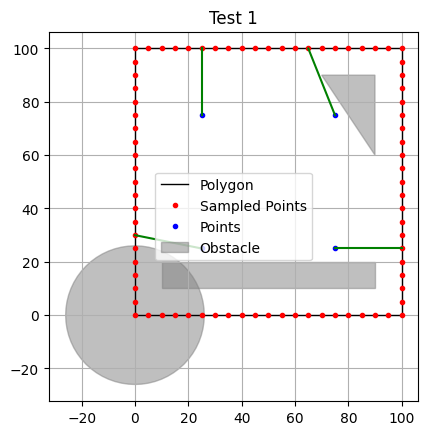

In [7]:
# 定义多边形边界和关键点
polygon = Polygon([(0, 0), (100, 0), (100, 100), (0, 100)])
points = [Point(25, 25), Point(75, 25), Point(75, 75), Point(25, 75)]
obstacles = [Polygon([(70, 90), (90, 60), (90, 90)]), box(10, 10, 90, 20), Point(0.0, 0.0).buffer(26.0)]
# obstacles = []
lines = generate_connection_lines(points, polygon, obstacles, samples_per_edge=20)

_, ax = plt.subplots()

# 绘制多边形
x_poly, y_poly = polygon.exterior.xy
ax.plot(x_poly, y_poly, "k-", linewidth=1, label="Polygon")

# 多边形采样点
sampled = generate_sampled_points(polygon)
ax.plot(
    [p.x for p in sampled],
    [p.y for p in sampled],
    "ro",
    markersize=3,
    label="Sampled Points",
)

# 原始点
ax.plot(
    [p.x for p in points], [p.y for p in points], "bo", markersize=3, label="Points"
)

# 障碍物绘制
for idx, obstacle in enumerate(obstacles):
    x_obs, y_obs = obstacle.exterior.xy
    label = "Obstacle" if idx == 0 else None
    ax.fill(x_obs, y_obs, color="gray", alpha=0.5, label=label)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="green", linewidth=1.5)

ax.set_aspect("equal")
ax.set_title("Test 1")
ax.legend()
ax.grid(True)

# 简单测试, 例(2)

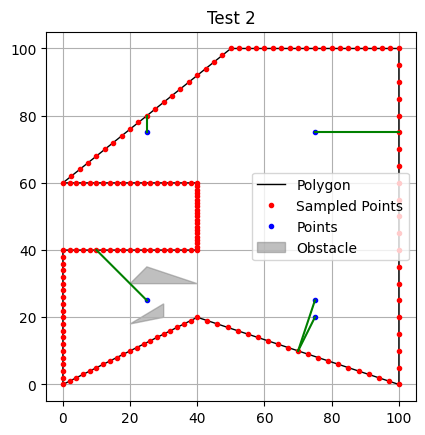

In [8]:
# 定义多边形边界和关键点
polygon = Polygon(
    [
        (0, 0),
        (40, 20),
        (100, 0),
        (100, 100),
        (50, 100),
        (0, 60),
        (40, 60),
        (40, 40),
        (0, 40),
    ]
)
points = [Point(25, 25), Point(75, 25), Point(75, 75), Point(25, 75), Point(75, 20)]
obstacles = [Polygon([(20, 18), (30, 20), (30, 24)]), Polygon([(20, 30), (40, 30), (25, 35)])]
# obstacles = []
lines = generate_connection_lines(points, polygon, obstacles, samples_per_edge=20)

_, ax = plt.subplots()

# 绘制多边形
x_poly, y_poly = polygon.exterior.xy
ax.plot(x_poly, y_poly, "k-", linewidth=1, label="Polygon")

# 多边形采样点
sampled = generate_sampled_points(polygon)
ax.plot(
    [p.x for p in sampled],
    [p.y for p in sampled],
    "ro",
    markersize=3,
    label="Sampled Points",
)

# 原始点
ax.plot(
    [p.x for p in points], [p.y for p in points], "bo", markersize=3, label="Points"
)

# 障碍物绘制
for idx, obstacle in enumerate(obstacles):
    x_obs, y_obs = obstacle.exterior.xy
    label = "Obstacle" if idx == 0 else None
    ax.fill(x_obs, y_obs, color="gray", alpha=0.5, label=label)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="green", linewidth=1.5)

ax.set_aspect("equal")
ax.set_title("Test 2")
ax.legend()
ax.grid(True)